<img src="resources/header.png"/>

# Exploratory data analysis with BayesDB

Authored by: [Feras Saad](http://fsaad.mit.edu) of the MIT Probabilistic Computing Project (Probcomp). Prepared for: The DARPA PPAML PI meeting, July 2017.

In this notebook, we will use BayesDB for exploratory data analysis on the [Gapminder dataset](http://www.gapminder.org/). Gapminder, originally assembled by Hans Rosling from the Gapminder Foundation, is an extensive longitudinal dataset of ∼320 global developmental indicators for 200 countries spanning over 3 centuries. These include variables from a broad set of categories such as education, health, trade, poverty, population growth, and mortality rates.

Our exploratory analysis will focus on a cross-sectional slice of Gapminder from the year 2002. This notebook will cover the following topics:

- Activating `jupyter_probcomp` magics and associated libraries.
- Creating a BayesDB file on disk, which will store data and models.
- Ingesting data from .csv files into BayesDB.
- Basic data manipulation, subsampling and plotting using SQL and `jupyter_probcomp` magics.
- Creating populations for database tables using the Metamodeling Language (MML).
- Producing visualizations Cross-Categorization (CrossCat), the default model discovery method for populations in BayesDB.
- Building an ensemble of CrossCat models, and visualizing their aggregate properties.
- Using the Bayesian Query Language (BQL) to query the ensemble of CrossCat models for exploratory tasks, such as (i) detecting variables which are probably dependent, and (ii) finding database records which are probably predictive of one another.

### Setting up the Jupyter environment

The first step is to load the `jupyter_probcomp.magics` library, which provides BayesDB hooks for data exploration, plotting, querying, and analysis through this Jupyter notebook environment. The second cell allows plots from matplotlib and javascript to be shown inline.

In [1]:
%load_ext jupyter_probcomp.magics

session_id: fsaad@probcomp-1.csail.mit.edu_2018-01-04T15:32:54.871608_0


In [2]:
%matplotlib inline
%vizgpm inline

<IPython.core.display.Javascript object>

### Creating a BayesDB `.bdb` file on disk

We next use the `%bayesdb` magic to create a `.bdb` file on disk named `gapminder.bdb`. This file will store all the data and models created in this session.

In [3]:
!rm -f resources/gapminder.bdb
%bayesdb resources/gapminder.bdb

u'Loaded: resources/gapminder.bdb'

### Ingesting data from a `.csv` file into a BayesDB table

The gapminder dataset is stored in the csv file `resources/gapminder.csv`. Each column of the csv file is a variable, and each row is a record. We use the `CREATE TABLE` BQL query, with the pathname of the csv file, to convert the csv data into a database table named `gapminder_full`.

In [4]:
%bql CREATE TABLE "gapminder_full" FROM 'resources/gapminder.csv'

Empty DataFrame
Columns: []
Index: []

Almost all datasets have missing values, and special tokens such as `NaN` or `NA` indicating a particular cell is missing. In the Gapminder data, empty strings are used. To tell BayesDB to treat empty strings as SQL `NULL` we use the `.nullify` command, followed by the name of the table and the string `''` which represents missing data. Over 30,000 cells have been converted to `NULL`, illustrating that the data is quite sparse.

In [5]:
%bql .nullify gapminder_full ''

Nullified 31876 cells


### Running basic queries on the table using BQL and SQL

Now that the Gapminder dataset has been loaded into at table, and missing values converted to `NULL`, we can run standard SQL queries to explore the contents of the data. For example, we can select the first 5 records. Observe that each row in the table is a particular country, and each column is a macreconomic variable. Scroll through the names in the header of the table to get a sense of the marcoeconomic variables in the dataset. 

In [6]:
%bql SELECT * FROM "gapminder_full" LIMIT 5;

country  % solid biofuels in total energy supply  \
0               Andorra                                      NaN   
1  United Arab Emirates                                        0   
2           Afghanistan                                      NaN   
3   Antigua and Barbuda                                      NaN   
4              Anguilla                                      NaN   

   0-14 yrs sex ratio  15-24 yrs sex ratio  15-49 yrs sex ratio  \
0                 NaN                  NaN                  NaN   
1             105.577              149.154              255.171   
2             106.663              108.533              109.218   
3                 NaN                  NaN                  NaN   
4                 NaN                  NaN                  NaN   

   2-wheeler, motorized, mortality per 100,000  50+ yrs sex ratio  \
0                                          NaN                NaN   
1                                          NaN            297.438   
2                                          NaN            102.749   
3                                          NaN                NaN   
4                                          NaN                NaN   

   adult (15+) literacy rate (%). total  age at 1st marriage (women)  \
0                                   NaN                          NaN   
1                             90.033845                    23.086737   
2                                   NaN                    17.839683   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   agricultural land (% of land area)  agriculture, value added (% of gdp)  \
0                           38.297872                                  NaN   
1                            6.674641                             1.395413   
2                           58.123668                            39.480416   
3                           29.545455                             2.024378   
4                                 NaN                                  NaN   

   aid received % of gni  aid received per person (current us$)  \
0                    NaN                                    NaN   
1                    NaN                                    NaN   
2              45.183059                              94.887932   
3               0.811517                              92.830926   
4                    NaN                                    NaN   

   air accidents affected  air accidents killed  \
0                     NaN                   NaN   
1                       0                     0   
2                     122                   122   
3                     NaN                   NaN   
4                     NaN                   NaN   

   alcohol consumption per adult 15+ (litres)  annual number of aids deaths  \
0                                       15.48                           NaN   
1                                        0.54                           NaN   
2                                        0.02                           350   
3                                        7.22                           NaN   
4                                         NaN                           NaN   

   armed forces personnel (% of labor force) wdi society war & peace  \
0                                                NaN                   
1                                           2.020136                   
2                                           0.319405                   
3                                                NaN                   
4                                                NaN                   

   armed forces personnel  arms exports (constant 1990 us$)  \
0                     NaN                               NaN   
1                   51000                          11000000   
2                   27000                               NaN   
3                

We can also find the total number of records (i.e. countries).

In [7]:
%bql SELECT COUNT(*) FROM "gapminder_full";

"COUNT"(*)
0         225

### Downsampling the columns in the table

The full `gapminder_t` table contains over 300 columns. In this notebook, our exploratory analysis will be based on a random subsample of 100 columns. To create the subsample, we use the `.subsample_columns` magic. The `--keep` flag accepts a list of column names which should be kept. We will keep the `Name` column, since it is the identifier for each record. The `--seed` flag specifies the random seed to create the subsample, which will ensure our analyses are reproducible. Finally, `gapminder_full` is the original table, `gapminder` is the name of the new table, and 100 is the number of columns to downsample to.

In [8]:
%bql .subsample_columns --seed=8 --keep=Country gapminder_full gapminder 100

Empty DataFrame
Columns: []
Index: []

### Creating a BayesDB population for the Gapminder data

The notion of a "population" is a central concept in BayesDB. For a standard database table, such as `gapminder`, each column is associated with a [data type](https://sqlite.org/datatype3.html), which in sqlite3 are `TEXT`, `REAL`, `INTEGER`, and `BLOB`. For a BayesDB population, each variable is associated with a _statistical data type_. These statistical types, such as `NOMINAL`, `NUMERICAL`, `MAGNITUDE`, and `COUNTS`, specify the set of values and default probability distributions used for building probabilistic models of the data in the population. In this tutorial, we will use the `NUMERICAL` and `NOMINAL` statistical data types.

We can use the `GUESS SCHEMA FOR <table>` command from the Metamodeling Language (MML) in BayesDB to guess the statistical data types of variables in the table. The guesses use heuristics based on the contents in the cells. The `num_distinct` column shows the number of unique values for that variable, and the `reason` column explains which heuristic was used to make the guess.

In [9]:
%mml GUESS SCHEMA FOR "gapminder"

column   stattype  \
0                                             country        key   
1                                stunt 0-4 unicef who    nominal   
2                                female 0-4 years (%)  numerical   
3            total 15-24 employment to population (%)  numerical   
4   total expenditure on health as percentage of g...  numerical   
5                              armed forces personnel  numerical   
6                              tax revenue (% of gdp)  numerical   
7                      subsistence incomes per person  numerical   
8             % solid biofuels in total energy supply  numerical   
9                            tb new and relapse cases  numerical   
10                       hiv incidence % (ages 15-49)  numerical   
11                                   total population  numerical   
12  primary completion rate, total (% of relevant ...  numerical   
13              co2 emission per person (metric tons)  numerical   
14                               rti 0-14 all age adj  numerical   
15                                        gdp pc test  numerical   
16                                forest coverage (%)  numerical   
17          water and sanitation aid (% of total aid)  numerical   
18                    male long-term unemployment (%)  numerical   
19                                 children per woman  numerical   
20               total 25-54 labour to population (%)  numerical   
21                                     drought killed    nominal   
22  primary completion rate, male (% of relevant a...  numerical   
23          total reserves (% of total external debt)  numerical   
24                       dots population coverage (%)  numerical   
25  government and civil society aid (% of total aid)  numerical   
26                    long term unemployment rate (%)  numerical   
27                 hydro production, per person (toe)  numerical   
28                                    epidemic killed  numerical   
29                   gdp per capita growth (annual %)  numerical   
30                           female self-employed (%)  numerical   
31             youth (15-24) literacy rate (%). total    nominal   
32                            total self-employed (%)  numerical   
33  market capitalization of listed companies (% o...  numerical   
34                          reported cases per 100000  numerical   
35  prevalence of current tobacco use among adults...  numerical   
36                                     storm affected  numerical   
37  private expenditure on health as percentage of...  numerical   
38  residential electricity consumption, per perso...  numerical   
39         other social services aid (% of total aid)  numerical   
40             gdp per working hour, (constant 1990$)  numerical   
41                        male salaried employees (%)  numerical   
42                   industry, value added (% of gdp)  numerical   
43                             working hours per week  numerical   
44  expenditure per student, primary (% of gdp per...  numerical   
45                              infant mortality rate  numerical   
46      mean years in school (men 25 years and older)  numerical   
47                                                hdi  numerical   
48                             female 20-39 years (%)  numerical   
49  poverty headcount ratio at rural poverty line ...    nominal   
50                          suicide 15-29 all age adj  numerical   
51                        forest products total (usd)  numerical   
52  motor vehicles (not 2-wheelers) per 1,000 popu...  numerical   
53                                          oda % gni    nominal   
54                         female service workers (%)  numerical   
55                                15-49 yrs sex ratio  numerical   
56               nuclear production, per person (toe)  numerical   
57           estimated hiv prevalence% - (ages 15-49)  numerical   
58                               ai

The `country` column has been identified as the `key`, since it is a unique identifer for each row. Many of the variables have been also correctly guessed  as `NUMERICAL`. A few variables have been incorrectly guessesd as `NOMINAL`, probably due to the sparsity in the dataset (the reason is that there are only a few distinct values for that variable in the table).

Now that we know the Gapminder variables and their statistical datatypes, we use MML to create a population for the `gapminder` table. The population schema uses the statistical types guessed by BayesDB (from the previous cell) for all variables, except for a set of manual overrides for the incorrect guesses.

In [10]:
%%mml
CREATE POPULATION FOR "gapminder" WITH SCHEMA (
    -- Use the guesses from the previous cell for all variables.
    GUESS STATTYPES OF (*);

    -- Manually override incorrectly guessed statistical types.
    SET STATTYPES OF
        "poverty headcount ratio at rural poverty line (% of rural population)",
        "stunt 0-4 unicef who",
        "drought killed",
        "youth (15-24) literacy rate (%). total",
        "oda % gni",
        "air accidents killed", "earthquake affected" 
    TO NUMERICAL;
);

Empty DataFrame
Columns: []
Index: []

### Visualizing joint distributions of data in the population

Equipped with the statistical data types of variables in the population, we can now use the plotting features of BayesDB to produce scatter plots and heatmaps for the marginal and (pairwise) joint distributions of variables of interest. The `.interactive_pairplot` command requires a flag `--population=<pop>` for the population name, followed a BQL query. It generates pairplots of the data in all pairs of columns yielded by the query . Below, we have selected five variables to pairplot (recall that we have 100 variables in total). What features do you notice?

In [11]:
%%bql
.interactive_pairplot --population=gapminder 
SELECT
    "life expectancy at birth",
    "tax revenue (% of gdp)",
    "income share held by highest 20%",
    "armed forces personnel",
    "mean years in school (men 25 years and older)"
FROM gapminder_full

<IPython.core.display.Javascript object>

Feel free to create more pairplots of the data before moving on to the next section.

### Creating a generator for the population using CrossCat

Now that we have created the `gapminder` population, the next step is to analyze the data by building probabilistic models which explain the data generating process. Probabilistic data analyses in BayesDB are specified by declaring `GENERATOR` for a population. The default generator in BayesDB is based on Cross-Categorization [(Crosscat)](http://jmlr.org/papers/v17/11-392.html). The CrossCat generator is a Bayesian factorial mixture model which learns a full joint distribution over all variables in the population, using a divide-and-conquer approach. We will explore CrossCat more in this notebook.

For now we use MML to declare the a generator for the `gapminder` population. Note that that we have left the schema (there are not specific model commands or overrides), which will apply the built-in default model discovery strategies. Specifying generators with custom modeling commands is the subject of the [next](satellites_predictive.ipynb) tutorial.

In [12]:
%mml CREATE GENERATOR FOR "gapminder";

Empty DataFrame
Columns: []
Index: []

After creating the generator, we now need to initialize `MODELS` for the generator. We can think of a `GENERATOR` as specifying a hypothesis space of explanations for the data generating process for the population, and each `MODEL` is a candidate hypothesis. We start by creating only 1 model, which is initialized __randomly__.

In [13]:
%mml INITIALIZE 1 MODEL FOR "gapminder";

Empty DataFrame
Columns: []
Index: []

### Visualizing a CrossCat model

As mentioned earlier, CrossCat learns the full joint distribution of all variables in the population using divide-and-conquer:

- First, CrossCat partitions the variables into a set of _views_; all the variables in a particular view are modeled jointly, and two variables in different views are independent of one another.
- Second, within each view, CrossCat clusters the rows using a non-parametric mixture model.

The name Cross-Categorization is derived from this two-step process: first categorize the variables into views, and then categorize the rows into clusters within each view of variables. It is important to note that two different views A and B are likely to induce different clusterings of the rows.

To get a sense of CrossCat's hypothesis space, we can render the hypothesis specified by a particular model using the `.render_crosscat [options] <generator> <model_number>` plotting command. The `--subsample=50` option says to only show a subsample of 50 rows in the rendering (even though the generator is modeling all countries in the `gapminder` population); `--rowlabels=country` specifies which column in the table to use to label the rows. Finally `gapminder 0` means to render the first (and only) model in the generator.

Creating figure...
[==============================] 100.00%
Rendering figure...


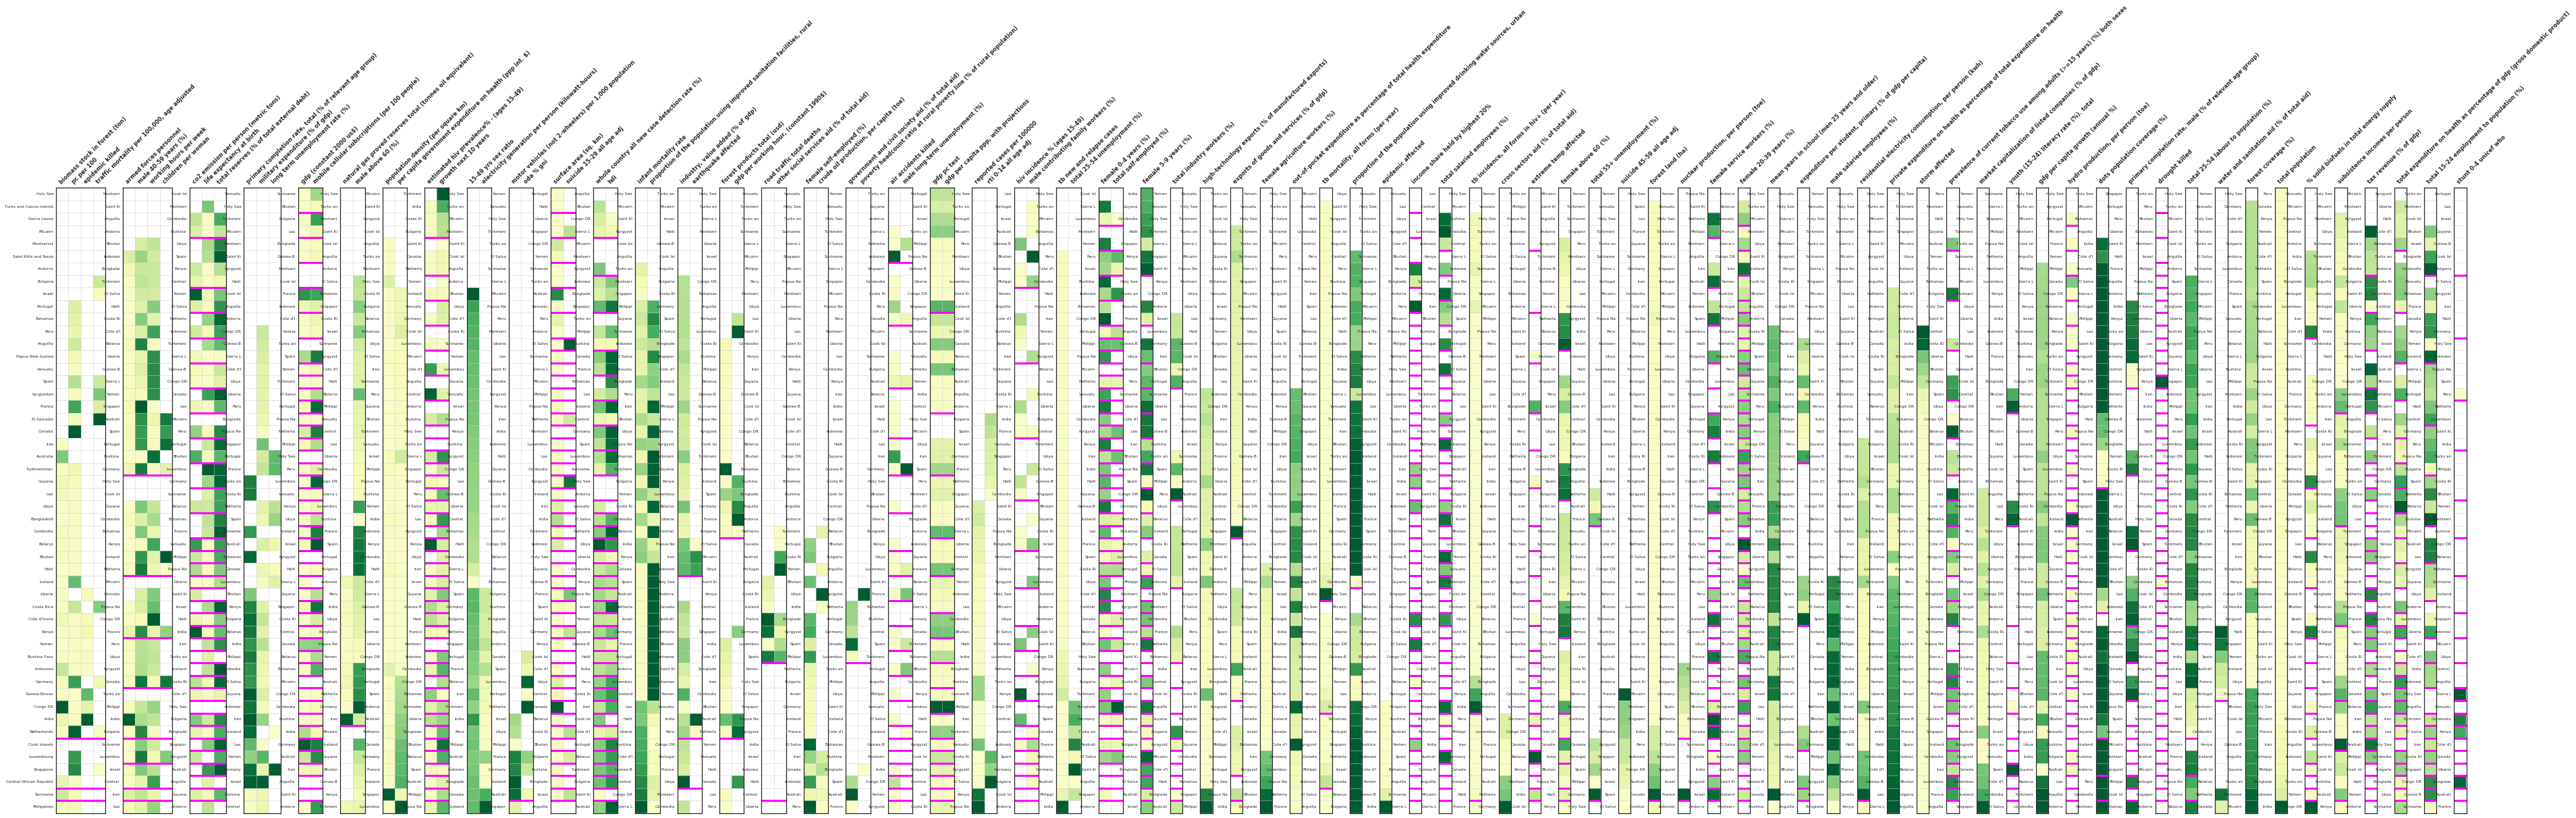

In [14]:
%mml .render_crosscat \
    --subsample=50 --rowlabels=country --xticklabelsize=small --yticklabelsize=xx-small --progress=True --width=64 \
    gapminder 0

__To view a full-size image of the rendering, either double click the image, or right-click and select "Open image in new tab."__

Again, we emphasize that the CrossCat hypothesis shown above is __randomly__ initialized based on the two-step clustering process we have described. Each block of columns shows a view of dependent variables. The clusters within a view are demarcated using solid pink lines. Each row is a country from `gapminder`. The color of a cell shows the magnitude of the data (normalized between 0 and 1, where light indicates lower values and dark indices higher values).

### Using BQL to query CrossCat models

In the CrossCat rendering, each pair of variables is either in the same view (and therefore probably dependent), or in different views (and therefore independent). We can query the detected probable dependencies between all pairs of variables using the `DEPENDENCE PROBABILITY` estimator in BQL. The next query produces a heatmap of all pairs of dependencies. In the heatmap below, each row and column is a variable, and the color of a cell is a value between 0 and 1 (lighter is nearer to 0, and darker is nearer to 1) indicating the amount of evidence for a predictive relationship or dependency between these two variables. Since we have initialized only 1 CrossCat model, each cell is exactly either 0 (if those variables are in different views), or 1 (variables are in the same view). Confirm that the blocks shown in the heatmap match up with the blocks of variables from the rendering. 

In [15]:
%bql .interactive_heatmap ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE VARIABLES OF gapminder;

<IPython.core.display.Javascript object>

### Improving Crosscat hypotheses using MML `ANALYZE`

Now that we have initialized a CrossCat hypothesis and visualized its column and row clusterings, it is time to improve our initial guess by exploring the hypothesis space to find hypotheses that better explain the data. In particular, our single CrossCat model has both spurious dependencies as well as independencies between variables which we would expect to be depedenct (study the heatmap and rendering, can you locate some of these pairs?).

We can improve the CrossCat model by using the MML `ANALYZE` command, which takes the name of a generator, an amount of iterations or seconds, and optional arguments. It then searches for improved hypotheses. Here, the `OPTIMIZED` keyword indicates to BayesDB to use a faster inference engine --- we generally recommend using this flag.

In [16]:
%mml ANALYZE "gapminder" FOR 200 ITERATIONS (OPTIMIZED);

Completed: 200 iterations in 64.292850 seconds.


Empty DataFrame
Columns: []
Index: []

Let us look at the new CrossCat after running 200 steps of analysis. Study the dependent variables. Can you identify a "theme" or "category" which summarizes each view? For example, the fourth view from the left has variables "residential electricty consumption", "electricity generation per person", and "hydro production", indicating that this may view might summarize energy variables. Which dependencies or independencies are still spurious?

Creating figure...
[==============================] 100.00%
Rendering figure...


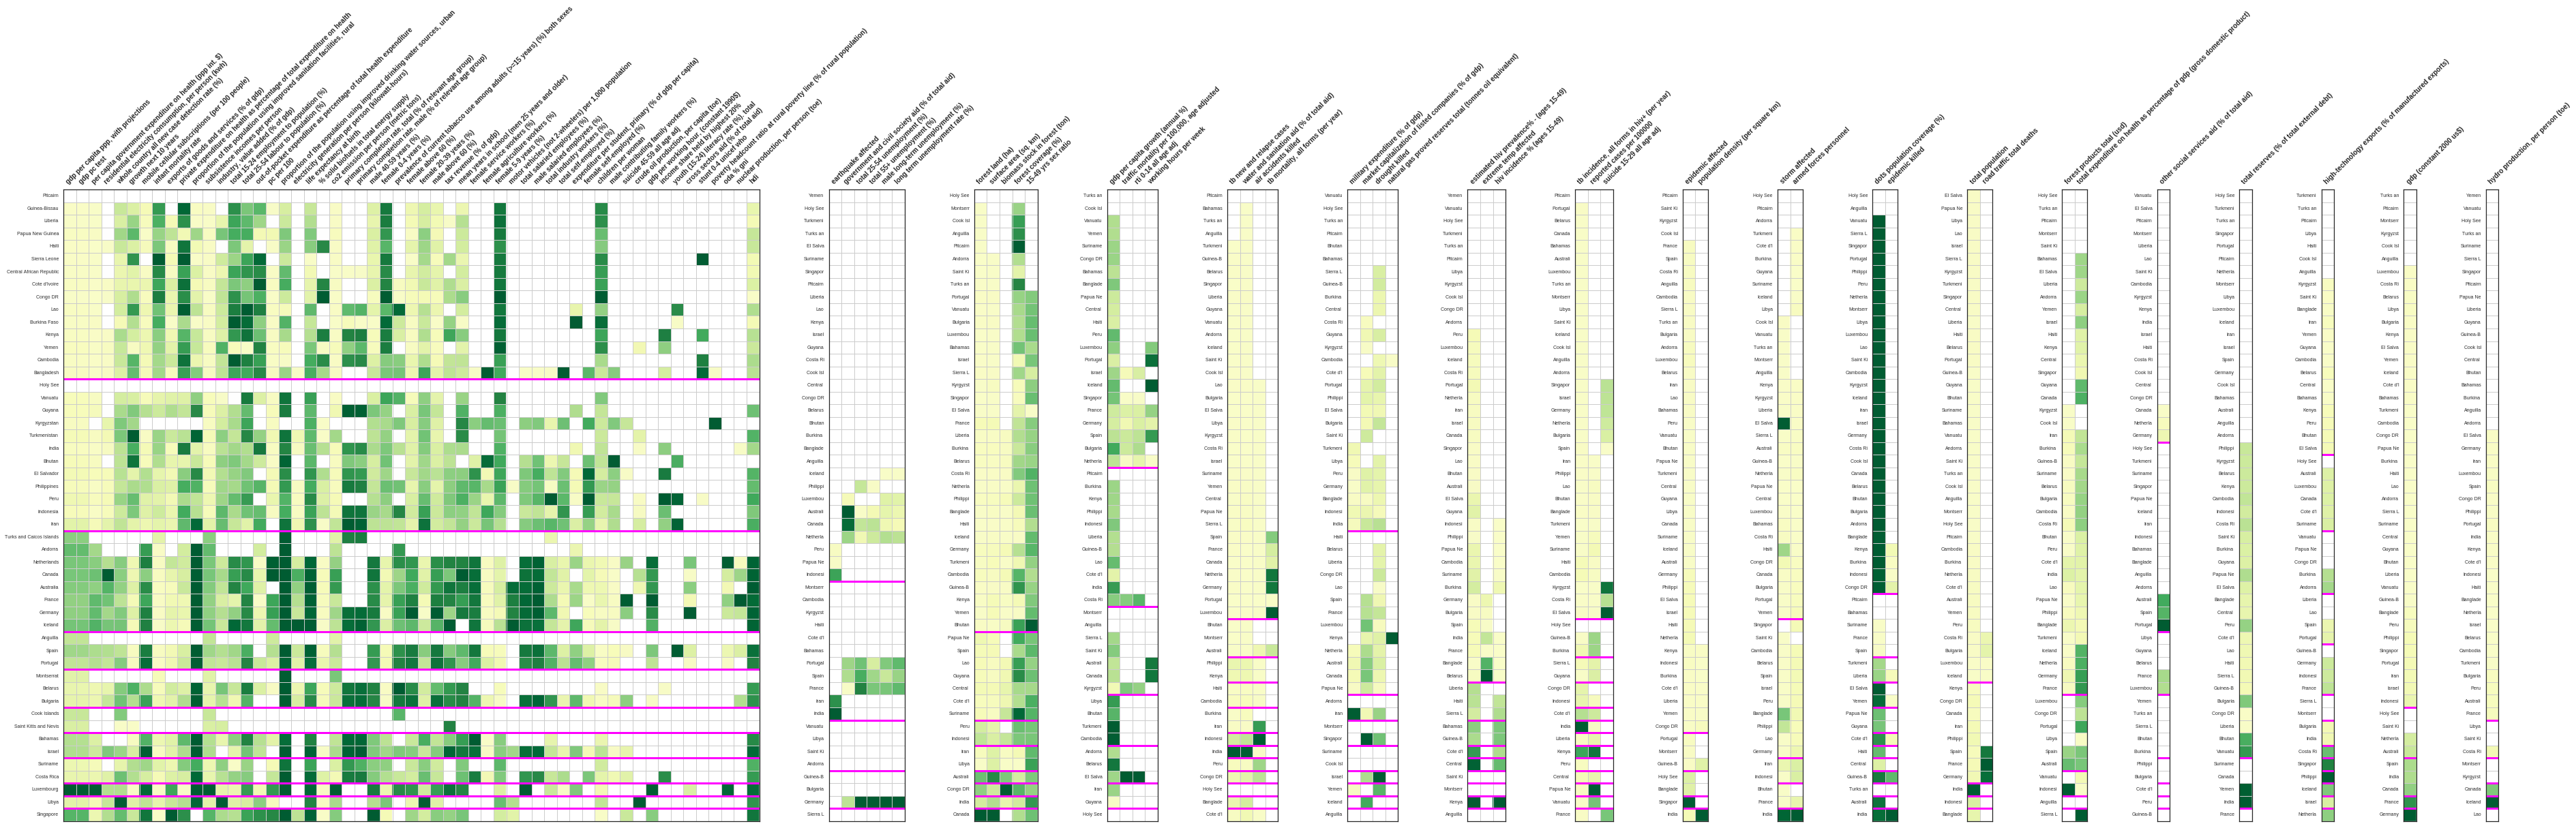

In [17]:
%mml .render_crosscat \
    --subsample=50 --rowlabels=country --xticklabelsize=small --yticklabelsize=xx-small --progress=True --width=64 \
    gapminder 0

We can again visualize the probability there exists a dependence, between all pairs of variables, using BQL. How does this heatmap differ qualitatively from the dependence probability heatmap we plotted prior to running `ANALYZE`?

In [18]:
%bql .interactive_heatmap ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE VARIABLES OF gapminder;

<IPython.core.display.Javascript object>

Recall that in addition to learning a clustering of variables, CrossCat additionally learns a clustering of the rows within each view. These clusters are separated using pink lines in the CrossCat rendering. We can use the `SIMILARITY IN THE CONTEXT OF <variable>` query in BQL to study CrossCat's row partition in the view of `<variable>`.

In the heatmap below, each row and column is a country, and the value of a cell (between 0 and 1) indicates the probability that those two countries are relevant for formulating predictions about each other. Do these clusters of countries make sense? The large cluster in the top-left the heatmap is largely African countries; the second cluster has mostly Asian countries, the third cluster represents Eastern European and former Soviet nations, and the fourth cluster contains Western Euroepan and Other Groups (WEOG).

In [19]:
%bql .interactive_heatmap --label0=rowid --label1=country --table=gapminder \
    ESTIMATE SIMILARITY IN THE CONTEXT OF  "life expectancy at birth" FROM PAIRWISE gapminder;

<IPython.core.display.Javascript object>

### Initializing more CrossCat models

So far, we used `INITIALIZE 1 MODEL FOR gapminder` to create a single model in the ensemble. As a result, all of our heatmaps (such as a variable dependencies and row similarities) had "sharp" values (either 1 or 0). Since CrossCat has a very large hypothesis space, we can significantly improve modeling by creating an ensemble of models, where each model searches the hypothesis space for hypotheses that fit the data well. All queries in BQL will then become weighted averages of the query results from each individual model in the ensemble.

The `%multiprocess on` magic activates multiprocessing BayesDB which allow us to initialize, analyze and run queries on analyses using multiple cores on the host machine.

In [20]:
%multiprocess on

Multiprocessing turned on from off.


The following MML command ensures the generator will have a total of 32 models in the ensemble (recall that we already initialized 1 model, so 31 new models will be added to the ensemble).

In [21]:
%mml INITIALIZE 32 MODELS IF NOT EXISTS FOR "gapminder";

Empty DataFrame
Columns: []
Index: []

Again, we run 1 minute of analysis.

In [22]:
%mml ANALYZE "gapminder" FOR 150 ITERATIONS (OPTIMIZED);

Completed: 150 iterations in 42.736535 seconds.
Completed: 150 iterations in 44.778665 seconds.
Completed: 150 iterations in 46.481403 seconds.
Completed: 150 iterations in 47.273818 seconds.
Completed: 150 iterations in 47.347174 seconds.
Completed: 150 iterations in 48.406770 seconds.
Completed: 150 iterations in 49.141705 seconds.
Completed: 150 iterations in 49.365588 seconds.
Completed: 150 iterations in 49.338755 seconds.
Completed: 150 iterations in 49.458492 seconds.
Completed: 150 iterations in 49.719604 seconds.
Completed: 150 iterations in 50.428582 seconds.
Completed: 150 iterations in 50.538529 seconds.
Completed: 150 iterations in 50.909171 seconds.
Completed: 150 iterations in 51.055064 seconds.
Completed: 150 iterations in 51.624536 seconds.
Completed: 150 iterations in 51.815518 seconds.
Completed: 150 iterations in 53.166588 seconds.
Completed: 150 iterations in 53.354388 seconds.
Completed: 150 iterations in 54.363939 seconds.
Completed: 150 iterations in 54.987801 s

Empty DataFrame
Columns: []
Index: []

Let use produce some renderings of the models (here we choose 5, 7 and 15). Where is there consensus among these three analyses? Where do they disagree?

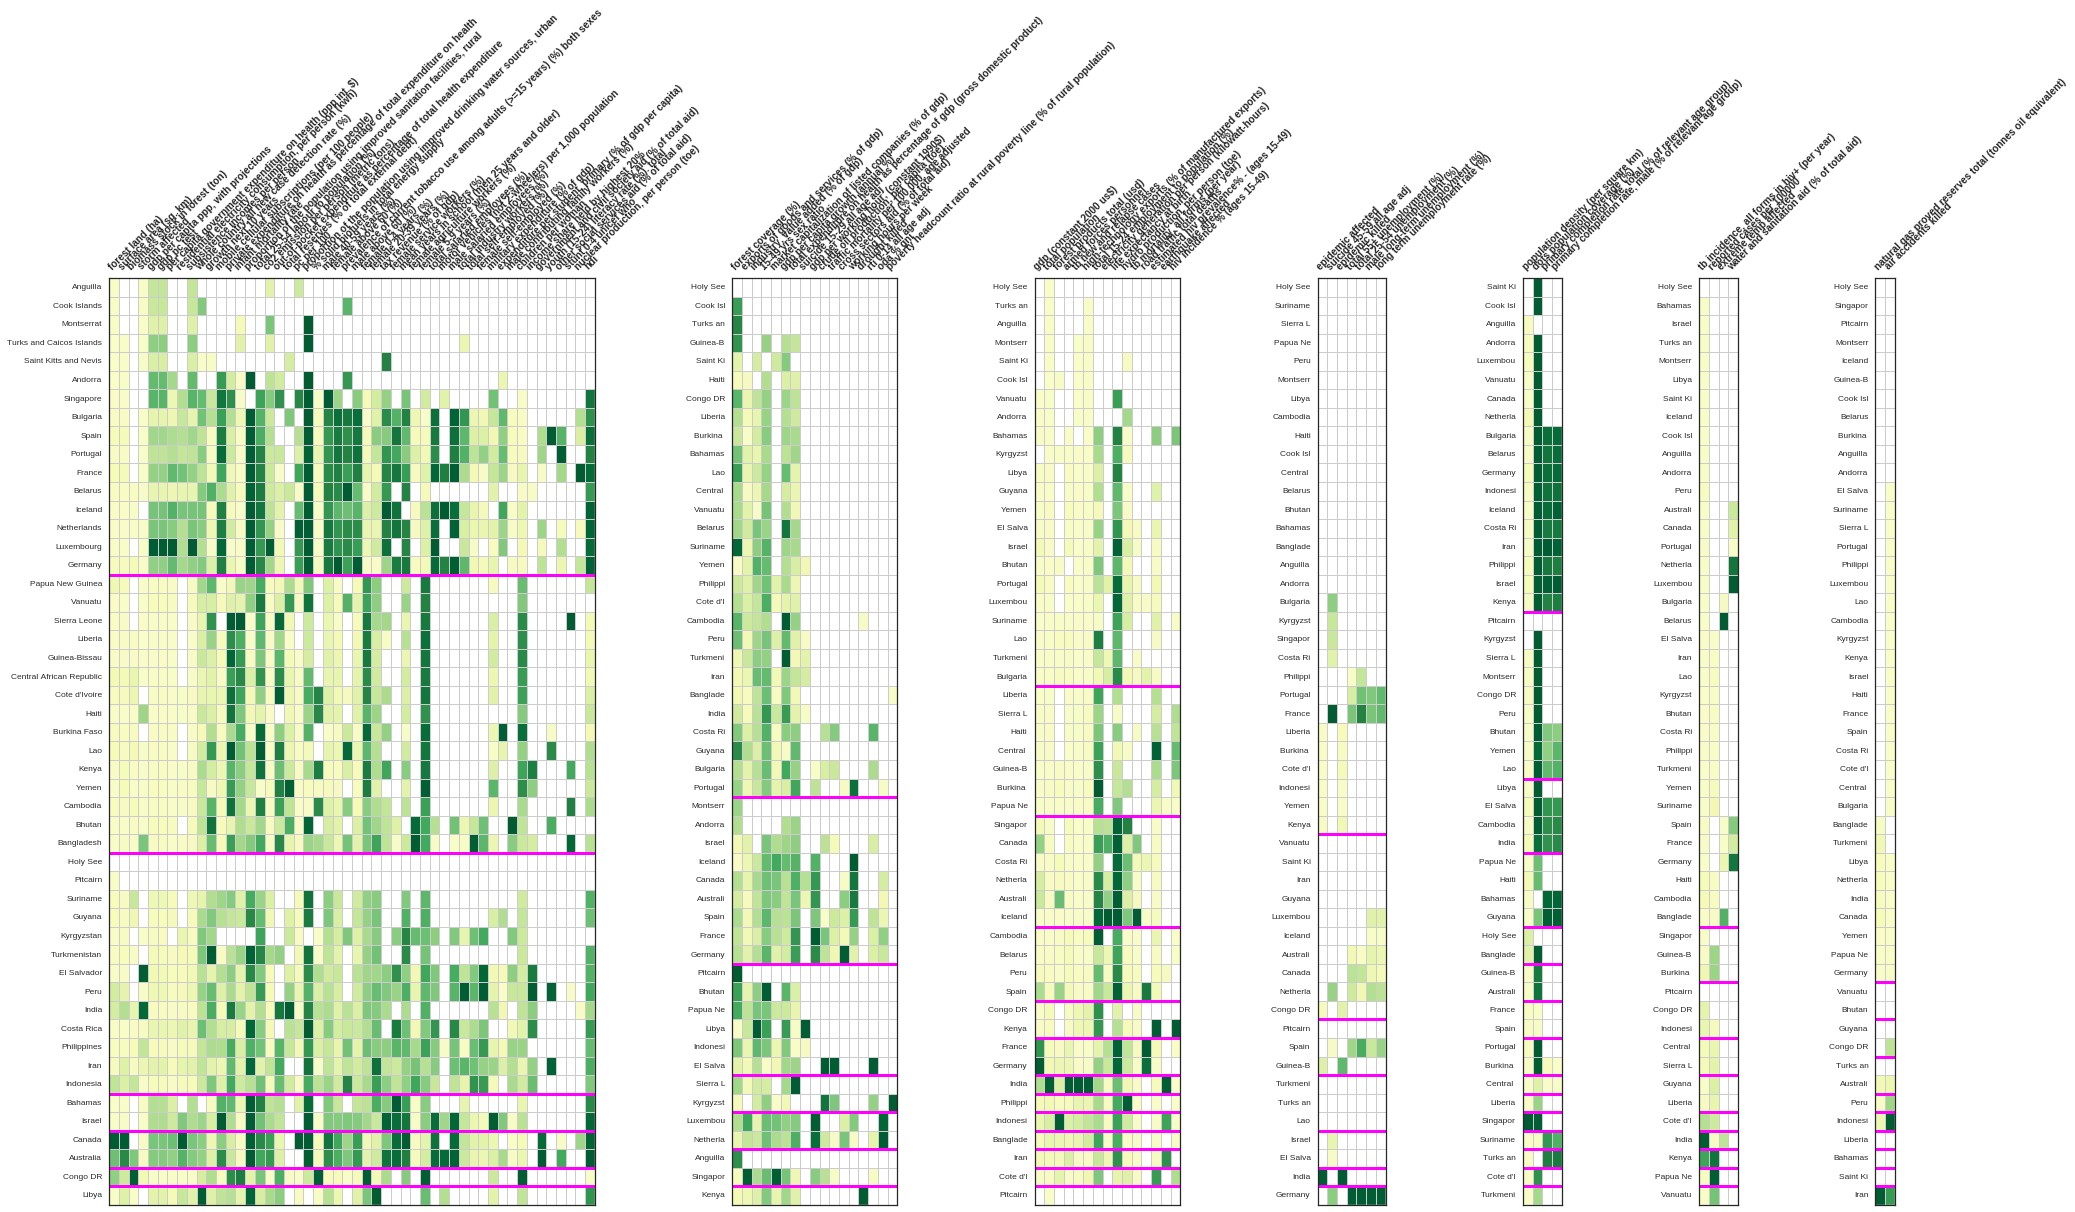

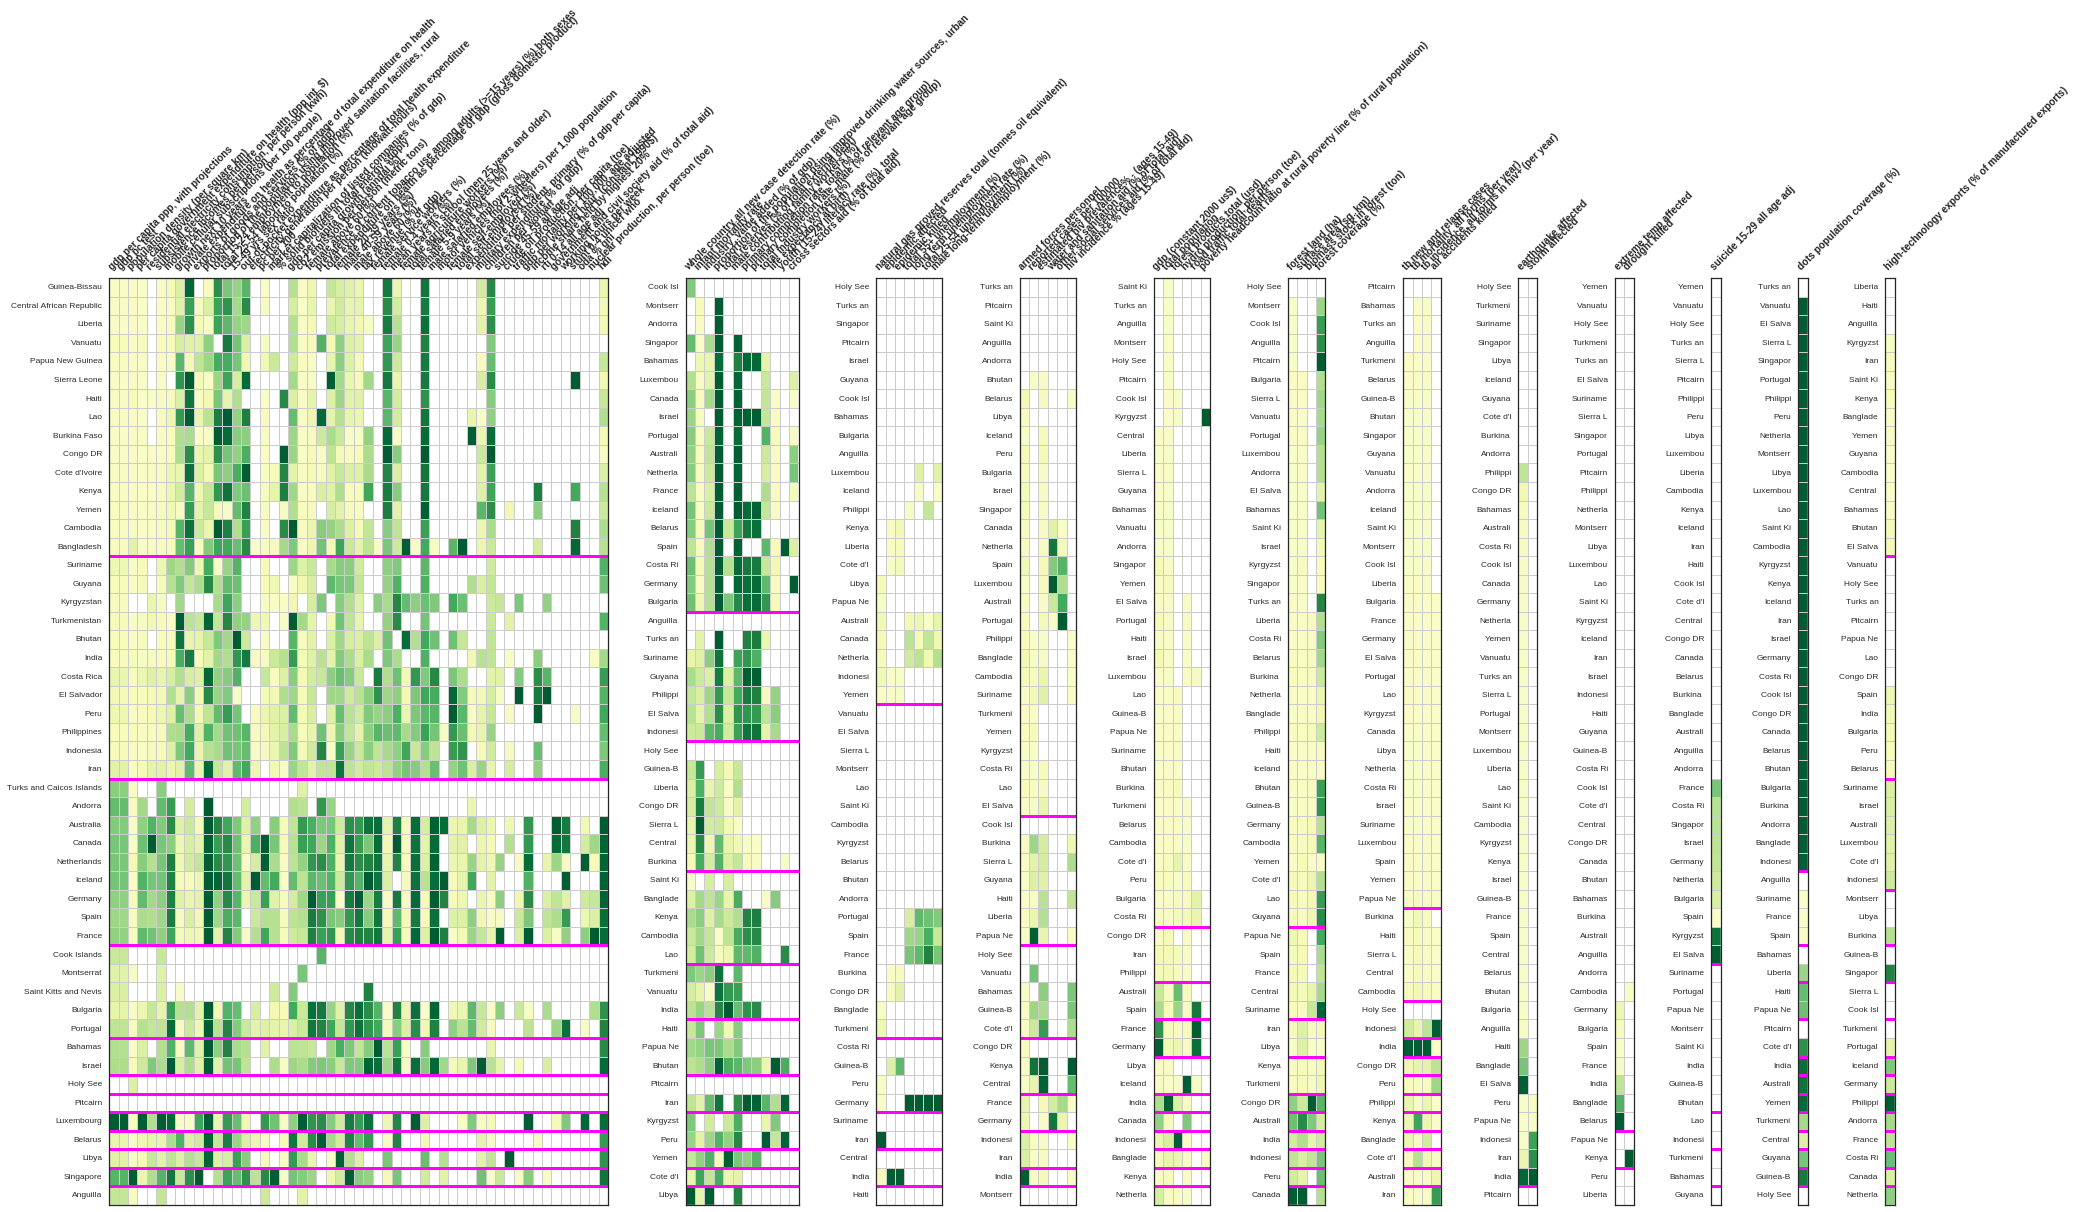

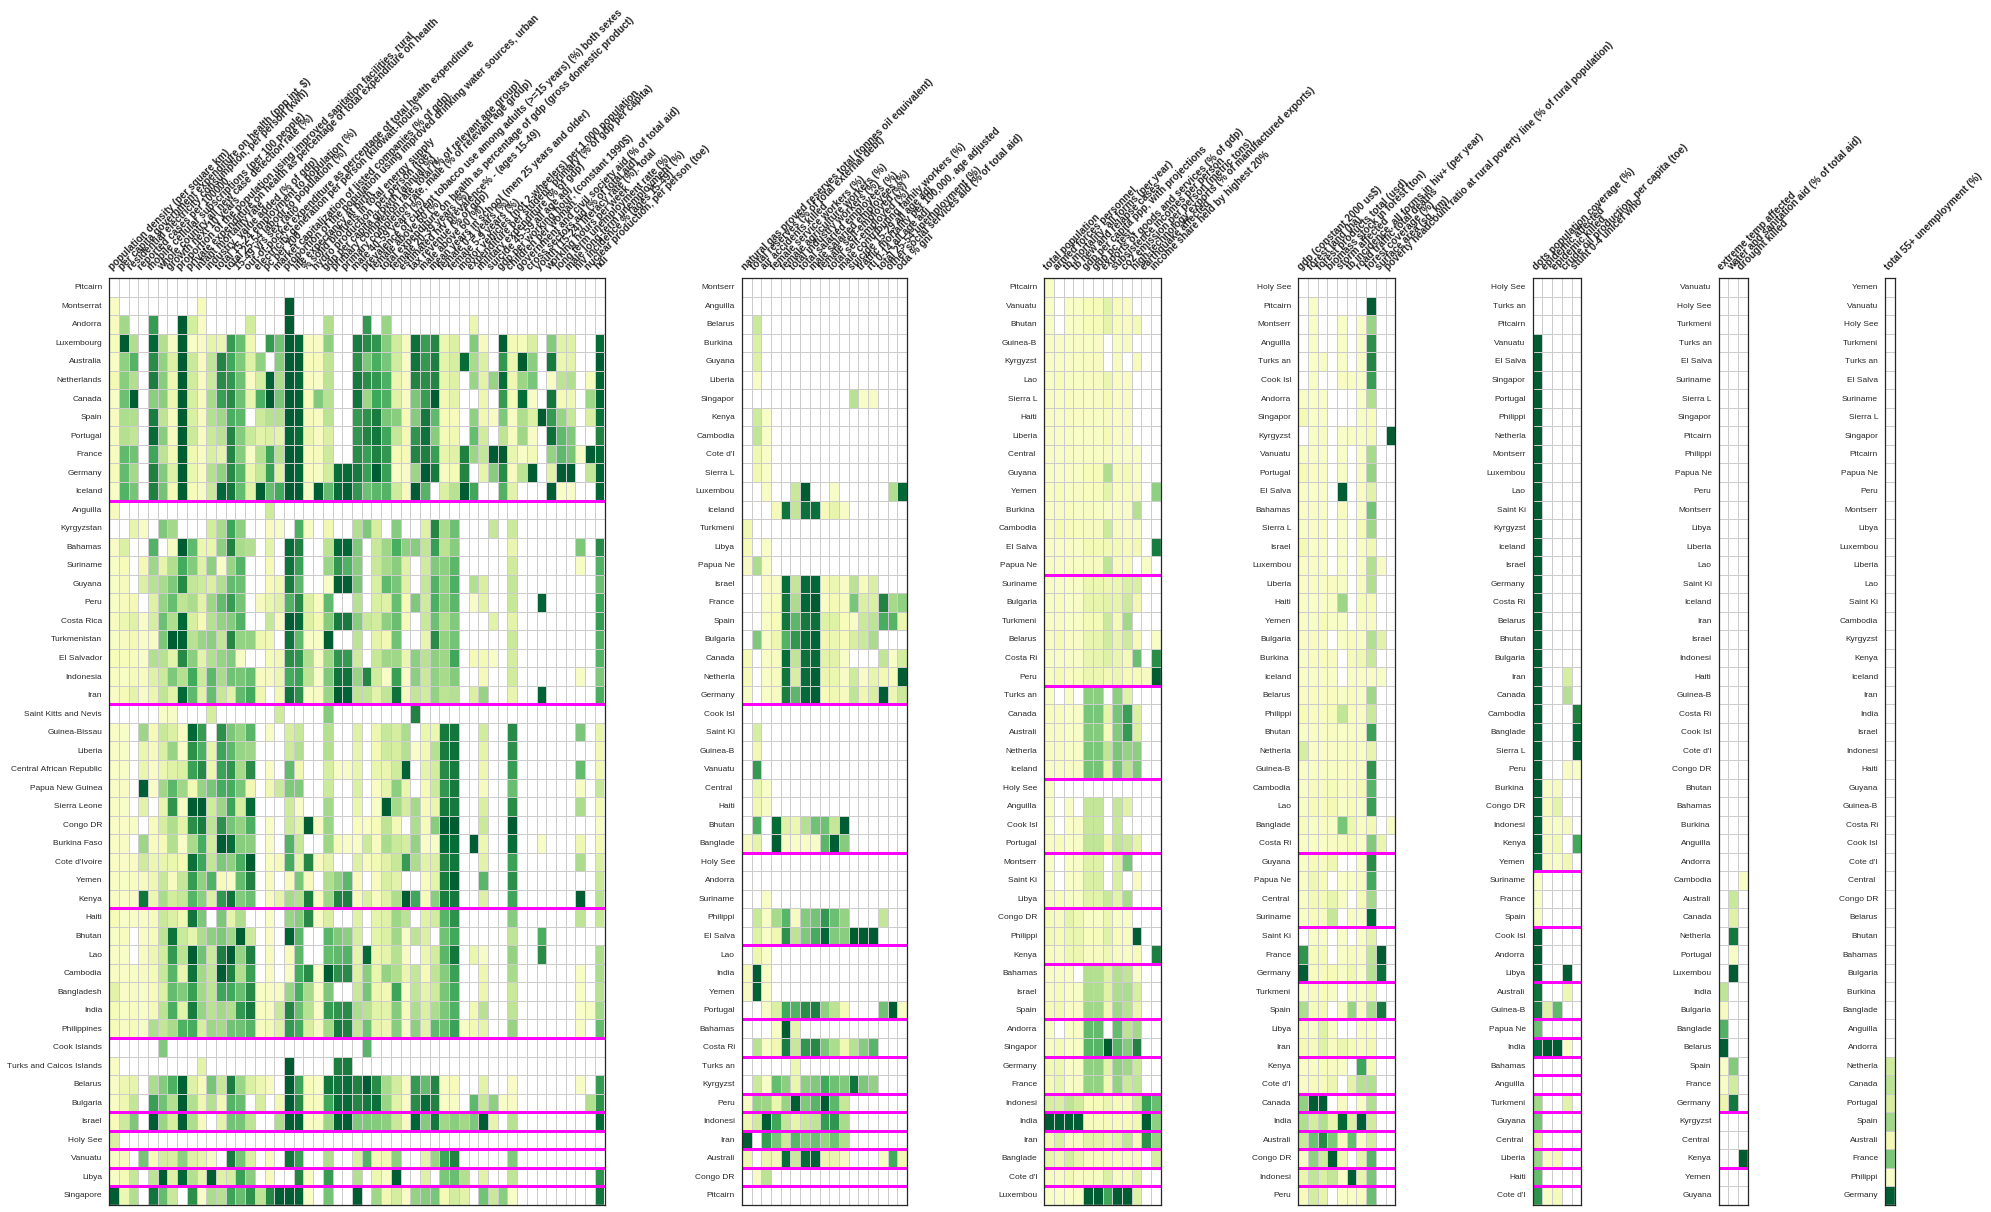

In [23]:
%mml .render_crosscat \
    --subsample=50 --rowlabels=country --xticklabelsize=small --yticklabelsize=x-small gapminder 5
%mml .render_crosscat \
    --subsample=50 --rowlabels=country --xticklabelsize=small --yticklabelsize=x-small gapminder 7
%mml .render_crosscat \
    --subsample=50 --rowlabels=country --xticklabelsize=small --yticklabelsize=x-small gapminder 15

### Exploring probable dependencies between variables and comparing CrossCat dependence probability to linear (Pearson R) correlation

As mentioned earlier, all BQL queries are aggregated across the 32 analyses in the ensemble. We will create a table named `dependencies` which contains the pairwise `DEPENDENCE PROBABILITY` values between the Gapminder variables. The value of a cell (between 0 and 1) is the fraction of analyses in the ensemble where those two variables are detected to be probably dependent (i.e. they are in the same view).

In [24]:
%%bql
CREATE TABLE dependencies AS
ESTIMATE
    DEPENDENCE PROBABILITY AS "depprob"
FROM PAIRWISE VARIABLES OF gapminder;

Empty DataFrame
Columns: []
Index: []

Here are five random rows from the `dependencies` table.

In [25]:
%bql SELECT * FROM "dependencies" ORDER BY RANDOM() LIMIT 5;

population_id                                    name0  \
0              1         gdp per capita growth (annual %)   
1              1             dots population coverage (%)   
2              1  % solid biofuels in total energy supply   
3              1                     female 5-9 years (%)   
4              1                    infant mortality rate   

                                               name1  depprob  
0                               female 0-4 years (%)  0.43750  
1                                                hdi  0.00000  
2  out-of-pocket expenditure as percentage of tot...  0.68750  
3              co2 emission per person (metric tons)  0.65625  
4              co2 emission per person (metric tons)  0.62500

We again summarize the `dependencies` table using a heatmap. Study this dependence heatmap, and compare it to the heatmap produced when there was only 1 model. Which common-sense dependencies were missed by the single model, but identified by the ensemble as probably dependent?

In [26]:
%bql .interactive_heatmap SELECT name0, name1, depprob FROM dependencies;

<IPython.core.display.Javascript object>

Let us compare dependence probabilities from CrossCat to linear (Pearson r) correlation values, a very common technique for finding predictive relationships. We can compute the Pearson R (and its p-value) in BayesDB using the `CORRELATION` and `CORRELATION PVALUE` queries. The following cell creates a table named `correlations`, which contains the R and p-value for all pairs of variables.

In [27]:
%%bql
CREATE TABLE "correlations" AS
ESTIMATE
    CORRELATION AS "correlation",
    CORRELATION PVALUE AS "pvalue"
FROM PAIRWISE VARIABLES OF "gapminder"

Empty DataFrame
Columns: []
Index: []

Here are five random rows from the `correlations` table.

In [28]:
%bql SELECT * FROM "correlations" ORDER BY RANDOM() LIMIT 5;

population_id                                     name0  \
0              1                          total population   
1              1                 suicide 45-59 all age adj   
2              1               forest products total (usd)   
3              1                               gdp pc test   
4              1  estimated hiv prevalence% - (ages 15-49)   

                                               name1  correlation    pvalue  
0                           life expectancy at birth     0.000474  0.768695  
1                              infant mortality rate     0.042641  0.163735  
2  private expenditure on health as percentage of...     0.003500  0.552784  
3                              extreme temp affected     0.032755  0.397374  
4  out-of-pocket expenditure as percentage of tot...     0.023825  0.109036

__Emphasis__: There is a signficiant difference between `DEPENDENCE PROBABILITY`, `CORRELATION`, and `CORRELATION PVALUE`. We outline these differences below, which will help us make comparisons between predictive relationships detected by CrossCat versus Pearson correlation.

- `DEPENDENCE PROBABILITY`: Returns a value between [0,1] indicating the __probability there exists__ a predictive relationship (statistical dependence) between two variables.

- `CORRELATION`: Returns a value between [0,1] indicating the __strength__ of the linear relationsip between two variables, where 0 means no linear correlation, and 1 means perfect linear correlation.

- `CORRELATION PVALUE`: Returns a value between (0, 1) indicating the tail probability of the observed correlation value between two variables, under the null hypothesis that the two variables have zero correlation.

Based on these distinctions, there is no immediate way to numerically compare `DEPENDENCE PROBABILITY` with `CORRELATION/CORRELATION PVALUE`. However, it is possible to compare the inferences about predictive relationships that each method gives rise to, which we do in the next section.

Let us first produce a heatmap of the raw correlation values. The following query shows the raw correlation values (between 0 and 1) for all pairs of variables where the p-value is less than 0.01 (note that we are not accounting for multiple-testing using e.g. Bonferroni correction). Pairs of variables where the p-value exceeds 0.01 (and thus the null hypothesis of independence cannot be rejected) are shown in gray. The sparsity of the data makes it difficult to draw inferences about many variables.

In [29]:
%bql .interactive_heatmap SELECT name0, name1, "correlation" FROM "correlations" WHERE "pvalue" < 0.01

<IPython.core.display.Javascript object>

Explore the heatmap, and compare it to the heatmap from `DEPENDENCE PROBABILITY`. The patterns of dependence relationships differ significantly, how?

We can use BQL to find variables which CrossCat believes are probably dependent, but correlation believes are independent (either the null hypothesis of independence cannot be rejected, or the correlation value is significant and near zero).

In [30]:
%%sql
SELECT
    "name0",
    "name1",
    "dependencies"."depprob",
    "correlations"."correlation",
    "correlations"."pvalue"
FROM
    "dependencies"
    JOIN "correlations"
    USING ("name0", "name1")
WHERE
    -- CrossCat: probability dependent.
    "dependencies"."depprob" > 0.85
    AND (
    -- Correlation: cannot reject null hypothesis of independence.
    "correlations"."pvalue" > 0.05
    OR (
    -- Correlation: linear relationship is significant and near zero.
    "correlations"."pvalue" < 0.05 AND "correlations"."correlation" < 0.05))

name0  \
0                                female 0-4 years (%)   
1                                  children per woman   
2              youth (15-24) literacy rate (%). total   
3   prevalence of current tobacco use among adults...   
4       mean years in school (men 25 years and older)   
5                                                 hdi   
6                              female 20-39 years (%)   
7                              female 20-39 years (%)   
8                              female 20-39 years (%)   
9                              female 20-39 years (%)   
10                             female 20-39 years (%)   
11                             female 20-39 years (%)   
12                             female 20-39 years (%)   
13                             female 20-39 years (%)   
14                             female 20-39 years (%)   
15      whole country all new case detection rate (%)   
16                               male 40-59 years (%)   
17  proportion of the population using improved sa...   
18  proportion of the population using improved dr...   
19                               female 5-9 years (%)   

                                                name1  depprob  correlation  \
0                              female 20-39 years (%)  0.93750     0.000076   
1                              female 20-39 years (%)  0.93750     0.037833   
2   proportion of the population using improved dr...  0.87500     0.189408   
3                              female 20-39 years (%)  0.93750     0.035962   
4                              female 20-39 years (%)  0.93750     0.016882   
5                              female 20-39 years (%)  0.87500     0.004118   
6                                female 0-4 years (%)  0.93750     0.000076   
7                                  children per woman  0.93750     0.037833   
8   prevalence of current tobacco use among adults...  0.93750     0.035962   
9       mean years in school (men 25 years and older)  0.93750     0.016882   
10                                                hdi  0.87500     0.004118   
11      whole country all new case detection rate (%)  0.90625     0.002621   
12                               male 40-59 years (%)  0.93750     0.014269   
13  proportion of the population using improved sa...  0.87500     0.006898   
14                               female 5-9 years (%)  0.93750     0.003966   
15                             female 20-39 years (%)  0.90625     0.002621   
16                             female 20-39 years (%)  0.93750     0.014269   
17                             female 20-39 years (%)  0.87500     0.006898   
18             youth (15-24) literacy rate (%). total  0.87500     0.189408   
19                             female 20-39 years (%)  0.93750     0.003966   

      pvalue  
0   0.906421  
1   0.008151  
2   0.062557  
3   0.037225  
4   0.095227  
5   0.412847  
6   0.906421  
7   0.008151  
8   0.037225  
9   0.095227  
10  0.412847  
11  0.508575  
12  0.106295  
13  0.285952  
14  0.395755  
15  0.508575  
16  0.106295  
17  0.285952  
18  0.062557  
19  0.395755

Let us try to determine why the dependence probability of `female 5-9 years (%)` with `female 20-39 (%)` is very high according to CrossCat (greater than 0.90), but the linear correlation coefficient is near 0 (and the null hypothesis of independence cannot be rejected anyway).

The next cell produces a scatter plot of these two variables. We notice that they are indeed dependent, although the pattern is quite strange; it has a piecewise relationship where `female 20-39` is linearly correlated with `female 5-9 years` with an upward trend for values of `female 5-9 years` less than 10, but with a downward trend for values of `female 5-9 years` greater than 10. What are some possible explanations for the piecewise relationship?

In [31]:
%bql .interactive_scatter SELECT "female 5-9 years (%)", "female 20-39 years (%)" FROM "gapminder"

<IPython.core.display.Javascript object>

This finding illustrates that CrossCat analyses are able to detect non-linear and heteroskedastic predictive relationships between variables, which match our common-sense intuitions. A similar pattern can be seen in the scatter plot between `female 20-39 years` and `children per woman`, shown in the next cell.

In [32]:
%bql .interactive_scatter SELECT "children per woman", "female 20-39 years (%)" FROM "gapminder"

<IPython.core.display.Javascript object>

We can use also BQL to find variables which CrossCat believes are probably independent, but correlation believes are dependent (a statistically significant non-zero correlation value, where we are using an R cutoff of 0.15). The following query shows a list of such variables.

In [33]:
%%sql
SELECT
    "name0",
    "name1",
    "dependencies"."depprob",
    "correlations"."correlation",
    "correlations"."pvalue"
FROM
    "dependencies"
    JOIN "correlations"
    USING ("name0", "name1")
WHERE
    -- CrossCat: high uncertainty about dependence probability.
    "dependencies"."depprob" < 0.05
    AND (
    -- Correlation: statistically significant dependence.
    "correlations"."pvalue" < 0.05 AND "correlations"."correlation" > 0.15)
LIMIT 10

name0  \
0  total expenditure on health as percentage of g...   
1                             armed forces personnel   
2                     subsistence incomes per person   
3                                   total population   
4                                        gdp pc test   
5                    long term unemployment rate (%)   
6                                    epidemic killed   
7         other social services aid (% of total aid)   
8             gdp per working hour, (constant 1990$)   
9                             working hours per week   

                                  name1  depprob  correlation    pvalue  
0             road traffic total deaths  0.03125     0.197904  0.006557  
1                     epidemic affected  0.03125     0.299929  0.001177  
2          total 25-54 unemployment (%)  0.03125     0.256035  0.009861  
3                     epidemic affected  0.03125     0.354467  0.000204  
4          total 25-54 unemployment (%)  0.03125     0.256035  0.009861  
5                 extreme temp affected  0.03125     0.475592  0.027345  
6  male contributing family workers (%)  0.00000     0.953075  0.023745  
7             road traffic total deaths  0.03125     0.346384  0.034344  
8                 extreme temp affected  0.00000     0.291643  0.046209  
9                  air accidents killed  0.00000     0.185851  0.031433

Let us genreate scatter plots of some these variables, such as `armed forces personnel` versus `epidemic affected`, and `working hours per week` versus `air accidents killed`, which linear correlations spuriously detects are dependent, but CrossCat correctly identifies as probably independent.

In [34]:
%bql .interactive_scatter SELECT "armed forces personnel", "epidemic affected" FROM "gapminder"

<IPython.core.display.Javascript object>

In [35]:
%bql .interactive_scatter SELECT "working hours per week", "air accidents killed" FROM "gapminder"

<IPython.core.display.Javascript object>

We notice that linear correlation is deceived into detecting a dependency due to a single outlier in both cases. As a non-parametric mixture model, CrossCat is more robust to outliers and irregular patterns in the data, especially when there is insufficient evidence in the data to result in CrossCat reporting probable dependencies (as is the case in the two scatter plots, with only one data point deviating from the zero-dependence trend).

Bonferroni correction for multiple testing would perhaps render the p-values of these correlations as statistically insignificant. However, Bonferroni is also highly conservative, and will cause many common-sense relationships to be insigificant as well under linear correlation. These design trade-offs are very common in drawing inferences from frequentist methods such Pearson R.

Some next questions you might explore include:

- For which variables do CrossCat and linear correation agree about dependencies?
- Which pairs of variables have the most uncertainty about their dependence probability (a dependence probability value of 0.5 represents the most uncertainy, or a light green color)?

### Finding countries which are predictively relevant to one another

Now that we have explored dependencies between variables found by CrossCat, we next move to finding which countries in the Gapminder population are relevant to formulating predictions about one another. Recall from the visualizations of CrossCat that, within each _view_ of dependent variables, CrossCat learns a clustering of the countries. These country clusterings will typically differ based on the view. Also recall that different CrossCat analyses in the ensemble (we have 32 in total) will find different clusterings for both variables and rows, which we aggregate over using BQL queries.

We will use the BQL `PREDICTIVE RELEVANCE` query to find rows which are relevant for formulating predictions about one another, in the "context" of a variable in the population. The context of a variable is the set of variables in the CrossCat view for the context variable. A full description of this query can be found in 

> _Probabilistic Search for Structured Data via Probabilistic Programming and Nonparametric Bayes_. Saad, F.; Casarsa, L.; and Mansinghka, V. arXiv preprint, arXiv:1704.01087. 2017. [PDF](https://arxiv.org/abs/1704.01087).

In this tutorial, we will focus only on the simplest queries for exploratory analysis.

The next set of queries are more efficient to run without multiprocessing, so we will disable it.

In [36]:
%multiprocess off

Multiprocessing turned off from on.


Our first query finds the top 15 countries which are relevant to formulating predictions about the `life expectancy at birth` (and variables in its context) for the `United States`. We find that the result set contains rich nations with Western-style democracies and similar standards of living to that of the US. Notice that the set of relevant countries in this case is not based on geographic features.

In [37]:
%%bql
.interactive_bar 
ESTIMATE
    "country",
    PREDICTIVE RELEVANCE
        TO EXISTING ROWS (country='United States')
        IN THE CONTEXT OF "life expectancy at birth"
        AS "Relevance to United States (Life Expectancy)"
FROM "gapminder"
ORDER BY "Relevance to United States (Life Expectancy)"
DESC LIMIT 15

<IPython.core.display.Javascript object>

We can also find the list of countries which are relevant to the `United States` in the context of `armed forces personnel`. The result set is now much different, where almost no countries are predictively relevant. Why?

In [38]:
%%bql
.interactive_bar 
ESTIMATE
    "country",
    PREDICTIVE RELEVANCE
        TO EXISTING ROWS (country='United States')
        IN THE CONTEXT OF "armed forces personnel"
        AS "Relevance to United States (Military Personnel)"
FROM "gapminder"
ORDER BY "Relevance to United States (Military Personnel)" DESC LIMIT 10

<IPython.core.display.Javascript object>

Let us sort the countires by their `armed forces personnel`. We notice that there are other countries whose `armed forces personnel` is on the same scale as the US. But none of these countries are typically considered to share the same macroeconomic or political characteristics as the United States, so are not detected as predictively relevant.

In [39]:
%bql SELECT "country", "armed forces personnel" FROM "gapminder" ORDER BY "armed forces personnel" DESC limit 10

country  armed forces personnel
0               China                 3755000
1               India                 3047000
2       United States                 1546000
3  Russian Federation                 1452000
4            Pakistan                  921000
5               Egypt                  799000
6              Brazil                  673000
7              Turkey                  617000
8                Iran                  585000
9           Indonesia                  582000

We now find the top 15 countries which are relevant to formulating predictions about the `life expectancy at birth` (and variables in its context) for the Ukraine. Notice that these countries are all Eastern European nations and former Soviet states. In this case, CrossCat has recovered relevances which are related to both geography as well as shared macroeconomic and political characteristics.

In [40]:
%%bql
.interactive_bar 
ESTIMATE
    "country",
    PREDICTIVE RELEVANCE
        TO EXISTING ROWS (country='Ukraine')
        IN THE CONTEXT OF "life expectancy at birth"
        AS "Relevance to Ukraine (Life Expectancy)"
FROM "gapminder"
ORDER BY "Relevance to Ukraine (Life Expectancy)" DESC LIMIT 15

<IPython.core.display.Javascript object>